In [418]:
############################################################################
# Name: Liam Navarre, Connor Deide
# Class: CPSC 322, Fall 2022
# Final Project
# 12/14/2022
#
# Description: This file contains an overview of our project and shows how
# we have prepared, used, and interpreted the data from our input files
############################################################################

In [419]:
import os
import math
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from project_application import project_utils
importlib.reload(project_utils)
from classifier_models import classifiers
importlib.reload(classifiers)
from classifier_models import classifier_utils
importlib.reload(classifier_utils)
from classifier_models import evaluators as eval
importlib.reload(eval)
from classifier_models.classifiers import MyDummyClassifier as Dummy_clf
from classifier_models.classifiers import MyNaiveBayesClassifier as NaiveBayes_clf
from classifier_models.classifiers import MyDecisionTreeClassifier as DecisionTree_clf
from classifier_models.classifiers import MyRandomForestClassifier as RandomForest_clf


# Introduction
* The dataset that we are using for our project comes from 2 different csv files we found on Kaggle
* These files contain information about the TV show 'The Office', where each instance in the dataset corresponds to an episode of the show
    * One of the attributes present in this dataset is an IMDb rating
    * This is the attribute we decided to attempt to classify
* Running this data through the classifiers present in 'classifiers.py' resulted in highly accurate predictions
* We believe this is primarily because another attribute within the dataset titled 'votes' contains a number of votes from registered IMDb users for each episode
    * These votes are then used by IMDb to help determine the rating for the episode, thus this attribute is highly correlated to the ratings classification
    * Acknowledging this, we decided to test our classifiers using a dataset without this attribute and the classification accuracy only dropped by a couple of percentage points for each classifier

### The block of code below contains the initial preperation of the data
* Reading in two dataframes from the two csv files
* Getting rid of duplicate and irrelevant attributes
* Merging the dataframes into one

In [420]:
# Read the data from file
the_office_data_1 = pd.read_csv('./data/the_office_series.csv')
the_office_data_2 = pd.read_csv('./data/the_office_episodes.csv')

# Remove unwanted attributes from the two tables (Duplicate and/or irrelevant attributes)
# From dataframe 1
the_office_data_1.pop("EpisodeTitle")
the_office_data_1.pop("Director")
the_office_data_1.pop("Writers")
# From dataframe 2
the_office_data_2.pop("Season")
the_office_data_2.pop("EpisodeNumInSeason")
the_office_data_2.pop("Title")
the_office_data_2.pop("OriginalAirDate")
the_office_data_2.pop("ProdCode")

# Join the data on the EpisodeNumOverall attribute
# Serves as a unique id
the_office_data = pd.merge(the_office_data_1, the_office_data_2, on="EpisodeNumOverall", how="outer")
display(the_office_data)

,EpisodeNumOverall,Season,About,Ratings,Votes,Viewership,Duration,Date,GuestStars,DirectedBy,WrittenBy,USViewers
0,0,1,The premiere episode introduces the boss and s...,7.5,4936,11.20,23,24 March 2005,NaN,Ken Kwapis,Ricky Gervais & Stephen Merchant and Greg Daniels,11200000.0
1,1,1,Michael's off color remark puts a sensitivity ...,8.3,4801,6.00,23,29 March 2005,NaN,Ken Kwapis,B. J. Novak,6000000.0
2,2,1,Michael leaves Dwight in charge of picking the...,7.8,4024,5.80,22,5 April 2005,NaN,Ken Whittingham,Paul Lieberstein,5800000.0
3,3,1,"Just for a laugh, Jim agrees to an alliance wi...",8.1,3915,5.40,23,12 April 2005,NaN,Bryan Gordon,Michael Schur,5400000.0
4,4,1,Michael and his staff challenge the warehouse ...,8.4,4294,5.00,23,19 April 2005,NaN,Greg Daniels,Greg Daniels,5000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
183,183,9,Dwight shoots Stanley with a bull tranquilizer...,8.0,1985,3.83,22,11 April 2013,NaN,Matt Sohn,Dan Sterling,3830000.0
184,184,9,The employees hold a paper airplane competitio...,8.0,2007,3.25,22,25 April 2013,NaN,Jesse Peretz,Halsted Sullivan & Warren Lieberstein,3250000.0
185,185,9,Dwight becomes regional manager after Andy qui...,9.0,2831,3.51,42,2 May 2013,Michael Imperioli,Jeffrey Blitz,Niki Schwartz-Wright,3510000.0
186,186,9,Dwight prepares for a marriage proposal and hi...,9.5,3914,4.56,43,9 May 2013,NaN,David Rogers,Brent Forrester,4560000.0


# Data Analysis
* As seen above, our original cleaned dataset contains 12 attributes and 188 instances
    * The attributes we decided to include in this data are as follows:
        - EpisodeNumOverall (int)
        - Season (int)
        - About (string)
        - Ratings (float)
        - Votes (int)
        - Viewership (float)
        - Duration (int)
        - Date (string)
        - GuestStars (string)
        - DirectedBy (string)
        - WrittenBy (string)
        - USViewers (float)

## Clean Data
* We are attempting to predict the IMDb ratings value for unseen instances
    * This value is a floating point number with one decimal, resulting in many possible ratings values
    * This large variation greatly decreases the probability of predicting a correct rating value
    * To help increase the probability, we decided to round the ratings values into integers so a rating value can fall between 0 and 10
* Below this python block is a graph showing the frequency of our ratings values after rounding

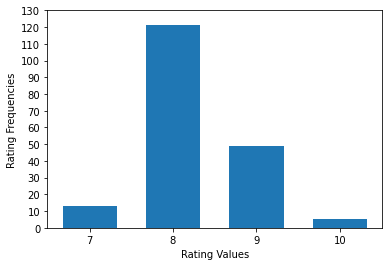

In [421]:
ratings_list = list(the_office_data.get("Ratings"))
round_ratings = []
for value in ratings_list:
    round_ratings.append(round(value))
# Replace Ratings column with rounded ratings
the_office_data["Ratings"] = round_ratings

ratings_freq = project_utils.get_instances(round_ratings)
# Prepare frequency data for matplotlib graph
xs = sorted(list(ratings_freq.keys()))
ys = []
for rating in xs:
    ys.append(ratings_freq[rating])
xrng = np.arange(len(xs))
yrng = np.arange(0, max(ys) + 10, 10)

plt.xlabel("Rating Values")
plt.ylabel("Rating Frequencies")
plt.bar(xrng, ys, .65)
plt.xticks(xrng, xs)
plt.yticks(yrng)

plt.show()

# Discretization
* We thought that discretizing the 'About' attribute would be helpful to our classification results
* This is because the About string contains a unique description about the contents of the episode
    * Being that each string is uniqe from one another, the classifier would not be able to learn anything helpful from this
    * However, if we were to descritize it in some way we would be able to help strengthen the classifiers
* The solution we came up with is to look for specific character names within the string
    * By parsing the string and adding any 'popular' character to a new list of strings, we hoped that this would help the classifier learn which combinations of characters led to a certain rating
* This discretizer can be found within the 'project_utils.py' file.

In [422]:
# Clean 'N/A' values from GuestStars attribute
guest_stars_list = list(the_office_data.get("GuestStars"))
cleaned_guest_stars_list = []
for val in guest_stars_list:
    if isinstance(val, float):
        tempVal = "No Guest Stars"
    else:
        tempVal = val
    cleaned_guest_stars_list.append(tempVal)

# About Descritization
about_list = list(the_office_data.get("About"))
cleaned_about_list = project_utils.about_discretizer(about_list)
dummy_list = []
for val in cleaned_about_list:
    newTemp = ""
    for i in range(len(val)):
        newTemp += val[i] + " "
    dummy_list.append(newTemp)
cleaned_about_list = dummy_list

the_office_data["About"] = cleaned_about_list

display(the_office_data)

,EpisodeNumOverall,Season,About,Ratings,Votes,Viewership,Duration,Date,GuestStars,DirectedBy,WrittenBy,USViewers
0,0,1,Other,8,4936,11.20,23,24 March 2005,NaN,Ken Kwapis,Ricky Gervais & Stephen Merchant and Greg Daniels,11200000.0
1,1,1,Michael Other,8,4801,6.00,23,29 March 2005,NaN,Ken Kwapis,B. J. Novak,6000000.0
2,2,1,Dwight Michael Other,8,4024,5.80,22,5 April 2005,NaN,Ken Whittingham,Paul Lieberstein,5800000.0
3,3,1,Dwight Jim Other,8,3915,5.40,23,12 April 2005,NaN,Bryan Gordon,Michael Schur,5400000.0
4,4,1,Michael Other,8,4294,5.00,23,19 April 2005,NaN,Greg Daniels,Greg Daniels,5000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
183,183,9,Dwight Jim Pam Andy Stanley Other,8,1985,3.83,22,11 April 2013,NaN,Matt Sohn,Dan Sterling,3830000.0
184,184,9,Jim Pam Andy Other,8,2007,3.25,22,25 April 2013,NaN,Jesse Peretz,Halsted Sullivan & Warren Lieberstein,3250000.0
185,185,9,Dwight Jim Andy Angela Other,9,2831,3.51,42,2 May 2013,Michael Imperioli,Jeffrey Blitz,Niki Schwartz-Wright,3510000.0
186,186,9,Dwight Jim Pam Andy Darryl Other,10,3914,4.56,43,9 May 2013,NaN,David Rogers,Brent Forrester,4560000.0


# Getting Predictions
* Below are the classification results on our original cleaned dataset

In [423]:
# Extract and remove the Ratings column (y) from the dataframe
y = list(the_office_data.get("Ratings"))
the_office_data.pop("Ratings")
# Build X with the remaining data
X = the_office_data.values.tolist()

# Dummy Classification
dummy_accuracy, dummy_error_rate, dummy_y_true, dummy_y_pred = project_utils.cross_val_predict(\
    X, y, eval, Dummy_clf(), True)

dummy_precision = eval.binary_precision_score(dummy_y_true, dummy_y_pred, None, 8)
dummy_recall = eval.binary_recall_score(dummy_y_true, dummy_y_pred, None, 8)
dummy_f_one = eval.binary_f1_score(dummy_y_true, dummy_y_pred, None, 8)

#Print the values found
print("===================================================")
print("Dummy Classifier Report With Complete Data Set")
print("===================================================")
print("Dummy Classifier: accuracy = "\
    + str(dummy_accuracy) + ", error rate = " + str(dummy_error_rate))
print("Precision: ", round(dummy_precision, 2))
print("Recall: ", round(dummy_recall, 2))
print("F-1: ", round(dummy_f_one, 2))
print()

# Naive Bayes Classification
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)

naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

#Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Complete Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

# Decision Tree Classification
tree_accuracy, tree_error_rate, tree_y_true, tree_y_pred = project_utils.cross_val_predict(\
    X, y, eval, DecisionTree_clf(), True)

tree_precision = eval.binary_precision_score(tree_y_true, tree_y_pred, None, 8)
tree_recall = eval.binary_recall_score(tree_y_true, tree_y_pred, None, 8)
tree_f_one = eval.binary_f1_score(tree_y_true, tree_y_pred, None, 8)

print("===================================================")
print("Decision Tree Classifier Report With Complete Data Set")
print("===================================================")
print("Decision Tree Classifier: accuracy = "\
    + str(tree_accuracy) + ", error rate = " + str(tree_error_rate))
print("Precision: ", round(tree_precision, 2))
print("Recall: ", round(tree_recall, 2))
print("F-1: ", round(tree_f_one, 2))
print()

Dummy Classifier Report With Complete Data Set
Dummy Classifier: accuracy = 0.65, error rate = 0.35
Precision:  0.64
Recall:  1.0
F-1:  0.78

Naive Bayes Classifier Report With Complete Data Set
Naive Bayes Classifier: accuracy = 0.88, error rate = 0.12
Precision:  1.0
Recall:  1.0
F-1:  1.0

Decision Tree Classifier Report With Complete Data Set
Decision Tree Classifier: accuracy = 0.9, error rate = 0.1
Precision:  1.0
Recall:  1.0
F-1:  1.0



# A Note on our Random Forest Classifier Implementation
* While we were close, we were not able to get the predictions working for the Random Forest Classifier
* It seems that the function call to get a prediction back from an individual tree within the forest is resulting in a 'None' value
    * This has been confusing, considering our decision tree predictions are working and using the same function
* Unfortanetely, we do not have the time to solve this issue

In [424]:
# Random Forest Classification (NOT WORKING)
r_tree_accuracy, r_tree_error_rate, r_tree_y_true, r_tree_y_pred = project_utils.train_test_predict(\
    X, y, eval, RandomForest_clf(100, 5, 12))

r_tree_precision = eval.binary_precision_score(r_tree_y_true, r_tree_y_pred, None, 8)
r_tree_recall = eval.binary_recall_score(r_tree_y_true, r_tree_y_pred, None, 8)
r_tree_f_one = eval.binary_f1_score(r_tree_y_true, r_tree_y_pred, None, 8)

print("===================================================")
print("Random Forest Classifier Report With Complete Data Set")
print("===================================================")
print("Random Forest Classifier: accuracy = "\
    + str(r_tree_accuracy) + ", error rate = " + str(r_tree_error_rate))
print("Precision: ", round(r_tree_precision, 2))
print("Recall: ", round(r_tree_recall, 2))
print("F-1: ", round(r_tree_f_one, 2))
print()


Random Forest Classifier Report With Complete Data Set
Random Forest Classifier: accuracy = 0.0, error rate = 1.0
Precision:  0
Recall:  0
F-1:  0



### Reflection 
We found our Precision, Recall, and F-1 score to be 0 when we give it the prediction of 10. This is because currently our precision, recall, and F-1 score work soley with binary classification. Our data set is classified into 4 categories so our binary scores will result in 1 or 0. If we were to give our most common prediction of 8, our score would result in 1. We also found a high accuracy of 88% when trying to gain predictions on the dataset. With an error rate of 12%, we are confident on our predictions based on 4 different categories

## Predictions Based on Different Attributes 

After finding our results when comparing against our entire cleaned dataset, we were interested in testing the accuracy based on certain attributes. We are curious to see if we can find a correlation to what attributes are "weighted" the most. We wanted to test against the Viewership, Guest Star, Director, Writer, Duration, and Votes Attributes. 

### Prediction Based on About

In [425]:
# We retain the same Y from the previous Naive Bayes Classification
# Extract the about column from the dataframe
about = list(the_office_data.get("About"))

# Build X with the remaining data
X = [[about[i]] for i in range(len(about))]

# Dummy Classification
print("===================================================")
print("Dummy Classifier Report With About Data Set")
print("===================================================")
print("Dummy Classifier: accuracy = "\
    + str(dummy_accuracy) + ", error rate = " + str(dummy_error_rate))
print("Precision: ", round(dummy_precision, 2))
print("Recall: ", round(dummy_recall, 2))
print("F-1: ", round(dummy_f_one, 2))
print()

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With About Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

# Decision Tree Classification
tree_accuracy, tree_error_rate, tree_y_true, tree_y_pred = project_utils.cross_val_predict(\
    X, y, eval, DecisionTree_clf(), True)

tree_precision = eval.binary_precision_score(tree_y_true, tree_y_pred, None, 8)
tree_recall = eval.binary_recall_score(tree_y_true, tree_y_pred, None, 8)
tree_f_one = eval.binary_f1_score(tree_y_true, tree_y_pred, None, 8)

print("===================================================")
print("Decision Tree Classifier Report With About Data Set")
print("===================================================")
print("Decision Tree Classifier: accuracy = "\
    + str(tree_accuracy) + ", error rate = " + str(tree_error_rate))
print("Precision: ", round(tree_precision, 2))
print("Recall: ", round(tree_recall, 2))
print("F-1: ", round(tree_f_one, 2))
print()

Dummy Classifier Report With About Data Set
Dummy Classifier: accuracy = 0.65, error rate = 0.35
Precision:  0.64
Recall:  1.0
F-1:  0.78

Naive Bayes Classifier Report With About Data Set
Naive Bayes Classifier: accuracy = 0.78, error rate = 0.22
Precision:  0.85
Recall:  0.93
F-1:  0.89

Decision Tree Classifier Report With About Data Set
Decision Tree Classifier: accuracy = 0.81, error rate = 0.19
Precision:  0.83
Recall:  0.97
F-1:  0.89



### Prediction Based on Viewership

In [426]:
# We retain the same Y from the previous Naive Bayes Classification
# Extract the viewership column from the dataframe
viewership = list(the_office_data.get("Viewership"))

# Build X with the remaining data
X = [[viewership[i]] for i in range(len(viewership))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

print("===================================================")
print("Dummy Classifier Report With Viewership Data Set")
print("===================================================")
print("Dummy Classifier: accuracy = "\
    + str(dummy_accuracy) + ", error rate = " + str(dummy_error_rate))
print("Precision: ", round(dummy_precision, 2))
print("Recall: ", round(dummy_recall, 2))
print("F-1: ", round(dummy_f_one, 2))
print()

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Viewership Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

tree_accuracy, tree_error_rate, tree_y_true, tree_y_pred = project_utils.cross_val_predict(\
    X, y, eval, DecisionTree_clf(), True)

tree_precision = eval.binary_precision_score(tree_y_true, tree_y_pred, None, 8)
tree_recall = eval.binary_recall_score(tree_y_true, tree_y_pred, None, 8)
tree_f_one = eval.binary_f1_score(tree_y_true, tree_y_pred, None, 8)

print("===================================================")
print("Decision Tree Classifier Report With Viewership Data Set")
print("===================================================")
print("Decision Tree Classifier: accuracy = "\
    + str(tree_accuracy) + ", error rate = " + str(tree_error_rate))
print("Precision: ", round(tree_precision, 2))
print("Recall: ", round(tree_recall, 2))
print("F-1: ", round(tree_f_one, 2))
print()

Dummy Classifier Report With Viewership Data Set
Dummy Classifier: accuracy = 0.65, error rate = 0.35
Precision:  0.64
Recall:  1.0
F-1:  0.78

Naive Bayes Classifier Report With Viewership Data Set
Naive Bayes Classifier: accuracy = 0.79, error rate = 0.21
Precision:  0.97
Recall:  0.91
F-1:  0.94

Decision Tree Classifier Report With Viewership Data Set
Decision Tree Classifier: accuracy = 0.84, error rate = 0.16
Precision:  0.91
Recall:  0.97
F-1:  0.94



### Visualization of Ratings Based on Viewership

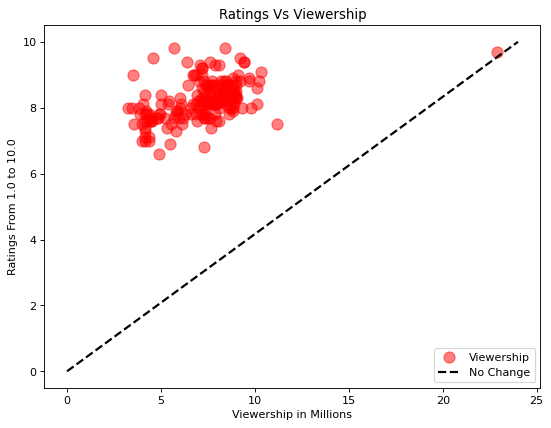

In [427]:
# Using original Ratings list so that the ratings are decimal values not integers     
plt.figure(figsize=(8,6), dpi=80)
x = [0,24]
y_plot = [0,10]
plt.scatter(viewership, ratings_list, s=100, c='red', alpha=0.5, label="Viewership")
plt.plot(x, y_plot, color='black', linestyle = "dashed", linewidth=2, label="No Change")
plt.title("Ratings Vs Viewership")
plt.xlabel("Viewership in Millions")
plt.ylabel("Ratings From 1.0 to 10.0")
plt.legend(loc = 4)
plt.show()

#### Reflection
We were able to receive an accuracy of 79% when testing the data based on the viewership attribute. This is still a strong accuracy rate but makes sense for there to be a higher error rate. There are plenty examples of shows or movies with a high viewership but a poor rating. We were able to produce precision, recall, and f-1 scores on this data set but they have no foundation in making predictions on four different categories. An interesting correlation can be noticed when trying different predictions of our data set in records to the precision, recall, and f-1 score. Although they are unbased, when our most common prediction of 8 was tested we received our highest scores. While when the least common prediciton of 10 had scores of 0. With the prediction of 9 recieving the second highest and 7 recieving our third highest. This correlates to the order of how common each prediction is. We also notice that on our average amount of viewership the office receives a higher rating than normal. This is seen by the cluster of nodes above the no change line

### Predictions Based On Guest Stars

In [428]:
# We retain the same Y from the previous Naive Bayes Classification

# Extract the Guest Stars column from the dataframe
guest_stars = list(the_office_data.get("GuestStars"))

# Build X with the remaining data
X = [[guest_stars[i]] for i in range(len(guest_stars))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

print("===================================================")
print("Dummy Classifier Report With Guest Stars Data Set")
print("===================================================")
print("Dummy Classifier: accuracy = "\
    + str(dummy_accuracy) + ", error rate = " + str(dummy_error_rate))
print("Precision: ", round(dummy_precision, 2))
print("Recall: ", round(dummy_recall, 2))
print("F-1: ", round(dummy_f_one, 2))
print()

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Guest Stars Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

tree_accuracy, tree_error_rate, tree_y_true, tree_y_pred = project_utils.cross_val_predict(\
    X, y, eval, DecisionTree_clf(), True)

tree_precision = eval.binary_precision_score(tree_y_true, tree_y_pred, None, 8)
tree_recall = eval.binary_recall_score(tree_y_true, tree_y_pred, None, 8)
tree_f_one = eval.binary_f1_score(tree_y_true, tree_y_pred, None, 8)

print("===================================================")
print("Decision Tree Classifier Report With Guest Stars Data Set")
print("===================================================")
print("Decision Tree Classifier: accuracy = "\
    + str(tree_accuracy) + ", error rate = " + str(tree_error_rate))
print("Precision: ", round(tree_precision, 2))
print("Recall: ", round(tree_recall, 2))
print("F-1: ", round(tree_f_one, 2))
print()

Dummy Classifier Report With Guest Stars Data Set
Dummy Classifier: accuracy = 0.65, error rate = 0.35
Precision:  0.64
Recall:  1.0
F-1:  0.78

Naive Bayes Classifier Report With Guest Stars Data Set
Naive Bayes Classifier: accuracy = 0.66, error rate = 0.34
Precision:  0.66
Recall:  1.0
F-1:  0.8

Decision Tree Classifier Report With Guest Stars Data Set
Decision Tree Classifier: accuracy = 0.65, error rate = 0.35
Precision:  0.64
Recall:  1.0
F-1:  0.78



### Visualization of Ratings Based on Guest Stars

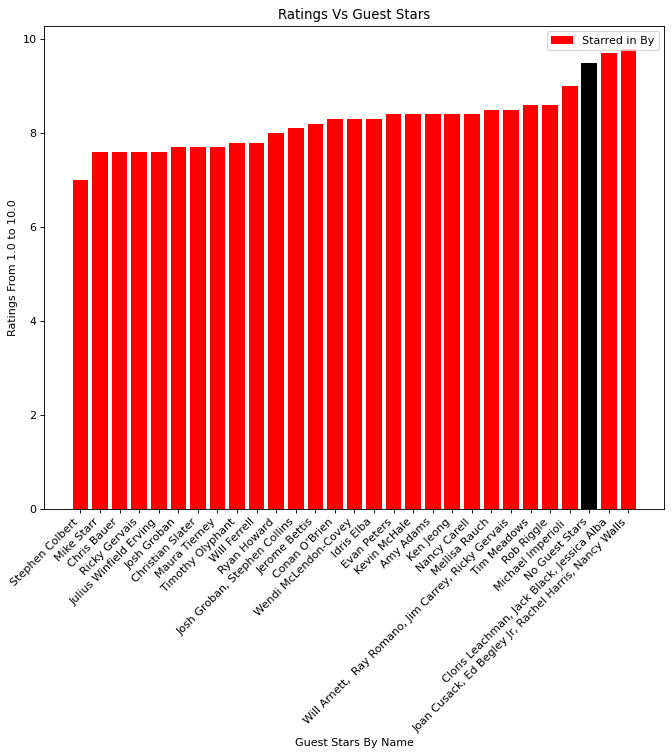

In [429]:
# Creating and sorting a directory with each Guest Star and their rating so the bars appear in order
guest_dir = {}
guest_rating = ratings_list.copy()
for key in cleaned_guest_stars_list:
    for value in guest_rating:
        guest_dir[key] = value
        guest_rating.remove(value)
        break
    
keys = list(guest_dir.keys())
values = list(guest_dir.values())
sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
guest_name = list(sorted_dict.keys())
guest_rat = list(sorted_dict.values())

# For Guest Stars
plt.figure(figsize=(10,8), dpi=80)
plt.bar(guest_name, guest_rat, color=["red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "black", "red", "red"], label="Starred in By")
plt.title("Ratings Vs Guest Stars")
plt.xlabel("Guest Stars By Name")
plt.ylabel("Ratings From 1.0 to 10.0")
plt.legend(loc = 1)
plt.xticks(rotation=45, ha='right') 
plt.show()

#### Reflection
We were able to receive an accuracy score of 65% and an error rate of 35%. It makes sense for classifiers accuracy to be lower and error rate to be higher when soley basing the prediction on whether or not a guest star was present in the episode. A guest star can cause the content of the show to improve but a guest star can also take away from the core material of the episode. We were able to receive a precision, recall, and F-1 score for our most common prediction of 8 but 0 is returned when testing against the other predictions. Again this is due to our dinary precision scores not being prepared to handle four categories based on predictions. We can also see from the graph that majority of the time it's better to not have a guest star than to actually have one. This could be due to the guest star taking away from the integrity of the show. 

### Predictions Based On Director

In [430]:
# We retain the same Y from the previous Naive Bayes Classification

# Extract the Directors column from the dataframe
directors = list(the_office_data.get("DirectedBy"))

# Build X with the remaining data
X = [[directors[i]] for i in range(len(directors))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Directors Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

print("===================================================")
print("Dummy Classifier Report With Directors Data Set")
print("===================================================")
print("Dummy Classifier: accuracy = "\
    + str(dummy_accuracy) + ", error rate = " + str(dummy_error_rate))
print("Precision: ", round(dummy_precision, 2))
print("Recall: ", round(dummy_recall, 2))
print("F-1: ", round(dummy_f_one, 2))
print()

tree_accuracy, tree_error_rate, tree_y_true, tree_y_pred = project_utils.cross_val_predict(\
    X, y, eval, DecisionTree_clf(), True)

tree_precision = eval.binary_precision_score(tree_y_true, tree_y_pred, None, 8)
tree_recall = eval.binary_recall_score(tree_y_true, tree_y_pred, None, 8)
tree_f_one = eval.binary_f1_score(tree_y_true, tree_y_pred, None, 8)

print("===================================================")
print("Decision Tree Classifier Report With Directors Data Set")
print("===================================================")
print("Decision Tree Classifier: accuracy = "\
    + str(tree_accuracy) + ", error rate = " + str(tree_error_rate))
print("Precision: ", round(tree_precision, 2))
print("Recall: ", round(tree_recall, 2))
print("F-1: ", round(tree_f_one, 2))
print()

Naive Bayes Classifier Report With Directors Data Set
Naive Bayes Classifier: accuracy = 0.68, error rate = 0.32
Precision:  0.73
Recall:  0.91
F-1:  0.81

Dummy Classifier Report With Directors Data Set
Dummy Classifier: accuracy = 0.65, error rate = 0.35
Precision:  0.64
Recall:  1.0
F-1:  0.78

Decision Tree Classifier Report With Directors Data Set
Decision Tree Classifier: accuracy = 0.67, error rate = 0.33
Precision:  0.71
Recall:  0.94
F-1:  0.81



### Visualization of Ratings Based on the Director

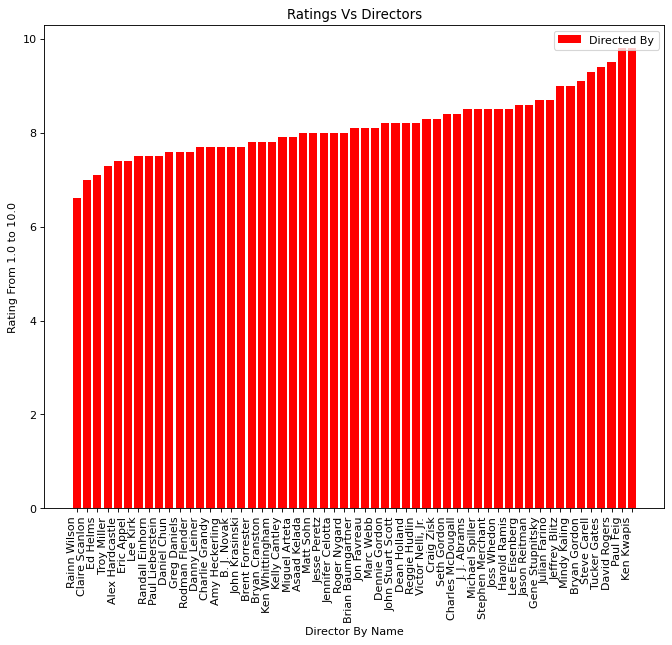

In [431]:
# Sorting the Vote by Director Dictionary so it is more presentable to read
director_dir = {}
tempVotes = ratings_list.copy()
for key in directors:
    for value in tempVotes:
        director_dir[key] = value
        tempVotes.remove(value)
        break
    
keys = list(director_dir.keys())
values = list(director_dir.values())
sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
dir_name = list(sorted_dict.keys())
dir_votes = list(sorted_dict.values())

# Displaying the votes by director in a bar graph
plt.figure(figsize=(10,8), dpi=80)
plt.bar(dir_name, dir_votes, color='red', label="Directed By")
plt.title("Ratings Vs Directors")
plt.xlabel("Director By Name")
plt.ylabel("Rating From 1.0 to 10.0")
plt.legend(loc = 1)
plt.xticks(rotation=90, ha='right') 
plt.show()

#### Reflection
We were able to get an accuracy of 68% and an error rate of 32% when basing the prediction off of soley the director. We were able to recieve precision, recall, and F-1 score when comparing based on our most common prediction. Again this values are unbased because they are not correctly set up to take care of 4 different categories of prediction. It makes sense for the accuracy to be lower because the styles of directing changes based on who's working on the project. So I would expect the predicition value to be harder to predict. We also gain from the graph what directors were the most successful and unsuccessful during their time as a director. This informs the producers of the office who were good and bad directors

### Predictions Based on Written By

In [432]:
# We retain the same Y from the previous Naive Bayes Classification

# Extract the Writers column from the dataframe
writers = list(the_office_data.get("WrittenBy"))

# Build X with the remaining data
X = [[writers[i]] for i in range(len(writers))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Writers Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

print("===================================================")
print("Dummy Classifier Report With Writers Data Set")
print("===================================================")
print("Dummy Classifier: accuracy = "\
    + str(dummy_accuracy) + ", error rate = " + str(dummy_error_rate))
print("Precision: ", round(dummy_precision, 2))
print("Recall: ", round(dummy_recall, 2))
print("F-1: ", round(dummy_f_one, 2))
print()

tree_accuracy, tree_error_rate, tree_y_true, tree_y_pred = project_utils.cross_val_predict(\
    X, y, eval, DecisionTree_clf(), True)

tree_precision = eval.binary_precision_score(tree_y_true, tree_y_pred, None, 8)
tree_recall = eval.binary_recall_score(tree_y_true, tree_y_pred, None, 8)
tree_f_one = eval.binary_f1_score(tree_y_true, tree_y_pred, None, 8)

print("===================================================")
print("Decision Tree Classifier Report With Writers Data Set")
print("===================================================")
print("Decision Tree Classifier: accuracy = "\
    + str(tree_accuracy) + ", error rate = " + str(tree_error_rate))
print("Precision: ", round(tree_precision, 2))
print("Recall: ", round(tree_recall, 2))
print("F-1: ", round(tree_f_one, 2))
print()

Naive Bayes Classifier Report With Writers Data Set
Naive Bayes Classifier: accuracy = 0.67, error rate = 0.33
Precision:  0.73
Recall:  0.9
F-1:  0.81

Dummy Classifier Report With Writers Data Set
Dummy Classifier: accuracy = 0.65, error rate = 0.35
Precision:  0.64
Recall:  1.0
F-1:  0.78

Decision Tree Classifier Report With Writers Data Set
Decision Tree Classifier: accuracy = 0.66, error rate = 0.34
Precision:  0.72
Recall:  0.93
F-1:  0.81



### Visualization of Ratings based on the Writer

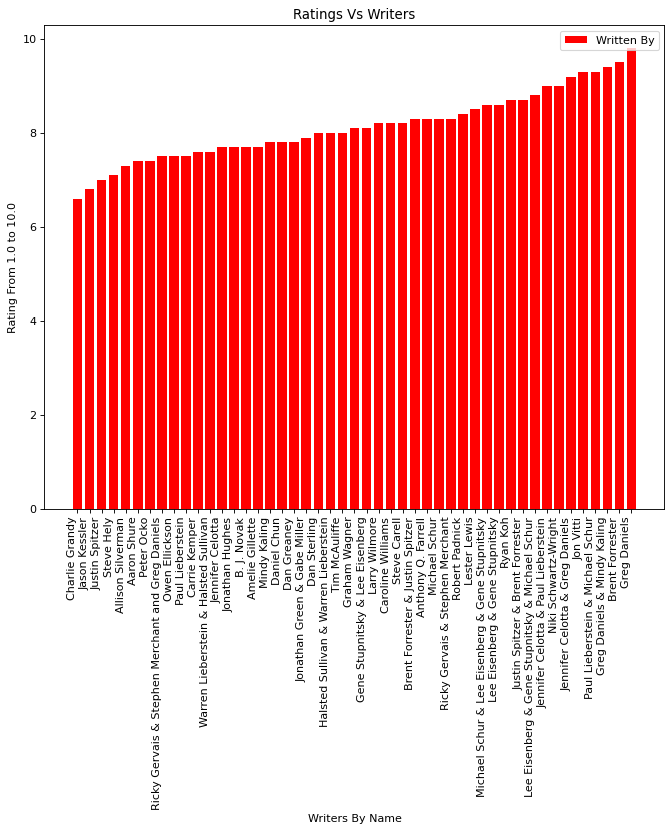

In [433]:
# Creating and sorting a directory with each writer and their rating so the bars appear in order
writer_dir = {}
writerRating = ratings_list.copy()
for key in writers:
    for value in writerRating:
        writer_dir[key] = value
        writerRating.remove(value)
        break
    
keys = list(writer_dir.keys())
values = list(writer_dir.values())
sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

# For Writer
wri_name = list(sorted_dict.keys())
wri_votes = list(sorted_dict.values())
plt.figure(figsize=(10,8), dpi=80)
plt.bar(wri_name, wri_votes, color='red', label="Written By")
plt.title("Ratings Vs Writers")
plt.xlabel("Writers By Name")
plt.ylabel("Rating From 1.0 to 10.0")
plt.legend(loc = 1)
plt.xticks(rotation=90, ha='right') 
plt.show()

#### Reflection 
We were able to receive an accuracy of 67% and an error rate of 33% from basing the predictions soley on who wrote the episode. It makes sense for the predictions accuracy to be lower and error rate to be higher because there are so many different ways to write the same episode. One writer could think an episode is a hit, but when comparing it to a perspective of another writer a different opinion could be shared. Meaning it's hard to make predicitions when there is such a variety of actors. The graph also informs us what Writers were the most and least successful. It can tell the producers of the Office to bring back a director that received a high rating, while not inviting those who didn't.  

### Predictions Based on Writers and Directors

In [434]:
# We retain the same Y from the previous Naive Bayes Classification

# Extract the Writers and Directors columns from the dataframe
writers = list(the_office_data.get("WrittenBy"))
directors = list(the_office_data.get("DirectedBy"))

# Build X with the remaining data
X = [[directors[i], writers[i]]  for i in range(len(writers))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Writers and Directors Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

print("===================================================")
print("Dummy Classifier Report With Complete Data Set")
print("===================================================")
print("Dummy Classifier: accuracy = "\
    + str(dummy_accuracy) + ", error rate = " + str(dummy_error_rate))
print("Precision: ", round(dummy_precision, 2))
print("Recall: ", round(dummy_recall, 2))
print("F-1: ", round(dummy_f_one, 2))
print()

tree_accuracy, tree_error_rate, tree_y_true, tree_y_pred = project_utils.cross_val_predict(\
    X, y, eval, DecisionTree_clf(), True)

tree_precision = eval.binary_precision_score(tree_y_true, tree_y_pred, None, 8)
tree_recall = eval.binary_recall_score(tree_y_true, tree_y_pred, None, 8)
tree_f_one = eval.binary_f1_score(tree_y_true, tree_y_pred, None, 8)

print("===================================================")
print("Decision Tree Classifier Report With Complete Data Set")
print("===================================================")
print("Decision Tree Classifier: accuracy = "\
    + str(tree_accuracy) + ", error rate = " + str(tree_error_rate))
print("Precision: ", round(tree_precision, 2))
print("Recall: ", round(tree_recall, 2))
print("F-1: ", round(tree_f_one, 2))
print()

Naive Bayes Classifier Report With Writers and Directors Data Set
Naive Bayes Classifier: accuracy = 0.78, error rate = 0.22
Precision:  0.88
Recall:  0.87
F-1:  0.87

Dummy Classifier Report With Complete Data Set
Dummy Classifier: accuracy = 0.65, error rate = 0.35
Precision:  0.64
Recall:  1.0
F-1:  0.78

Decision Tree Classifier Report With Complete Data Set
Decision Tree Classifier: accuracy = 0.68, error rate = 0.32
Precision:  0.71
Recall:  0.95
F-1:  0.81



#### Reflection
We were able to recieve an accuracy of 78% and an error rate of 22% when running the prediction on the writers and directors. It makes sense for this prediction model to have a high accuracy because it is taking both attributes of DirectedBy and WrittenBy. Meaning it should have a higher net accuracy than writer and director individually. Based on the who directed and wrote the episode, we have a good probability of predicting the episodes rating. We found it difficult to present each unique combination of director and writer. It lead to each column to be unreadable and add clutter to the EDA

### Predictions Based on Duration

In [435]:
# We retain the same Y from the previous Naive Bayes Classification

# Extract the Writers column from the dataframe
duration = list(the_office_data.get("Duration"))

# Build X with the remaining data
X = [[duration[i]] for i in range(len(duration))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Duration Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

print("===================================================")
print("Dummy Classifier Report With Complete Data Set")
print("===================================================")
print("Dummy Classifier: accuracy = "\
    + str(dummy_accuracy) + ", error rate = " + str(dummy_error_rate))
print("Precision: ", round(dummy_precision, 2))
print("Recall: ", round(dummy_recall, 2))
print("F-1: ", round(dummy_f_one, 2))
print()

tree_accuracy, tree_error_rate, tree_y_true, tree_y_pred = project_utils.cross_val_predict(\
    X, y, eval, DecisionTree_clf(), True)

tree_precision = eval.binary_precision_score(tree_y_true, tree_y_pred, None, 8)
tree_recall = eval.binary_recall_score(tree_y_true, tree_y_pred, None, 8)
tree_f_one = eval.binary_f1_score(tree_y_true, tree_y_pred, None, 8)

print("===================================================")
print("Decision Tree Classifier Report With Complete Data Set")
print("===================================================")
print("Decision Tree Classifier: accuracy = "\
    + str(tree_accuracy) + ", error rate = " + str(tree_error_rate))
print("Precision: ", round(tree_precision, 2))
print("Recall: ", round(tree_recall, 2))
print("F-1: ", round(tree_f_one, 2))
print()

Naive Bayes Classifier Report With Duration Data Set
Naive Bayes Classifier: accuracy = 0.69, error rate = 0.31
Precision:  0.71
Recall:  0.98
F-1:  0.82

Dummy Classifier Report With Complete Data Set
Dummy Classifier: accuracy = 0.65, error rate = 0.35
Precision:  0.64
Recall:  1.0
F-1:  0.78

Decision Tree Classifier Report With Complete Data Set
Decision Tree Classifier: accuracy = 0.7, error rate = 0.3
Precision:  0.71
Recall:  0.98
F-1:  0.82



### Visualization of Ratings Based on Duration

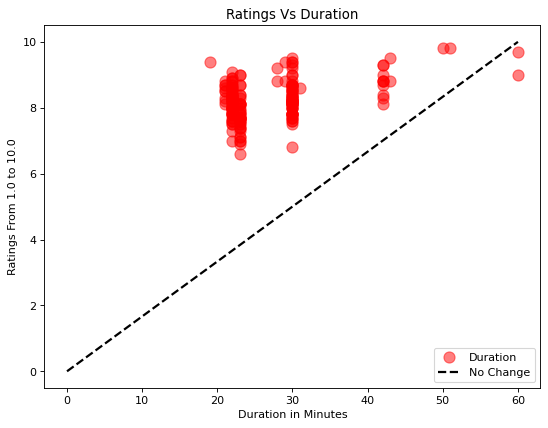

In [436]:
# For Duration
plt.figure(figsize=(8,6), dpi=80)
x = [0,60]
y_plot = [0,10]
plt.scatter(duration, ratings_list, s=100, c='red', alpha=0.5, label="Duration")
plt.plot(x, y_plot, color='black', linestyle = "dashed", linewidth=2, label="No Change")
plt.title("Ratings Vs Duration")
plt.xlabel("Duration in Minutes")
plt.ylabel("Ratings From 1.0 to 10.0")
plt.legend(loc = 4)
plt.show()

#### Reflection 
We were able to receive an accuracy score of 69% and an error rate of 31% when predicting based on the episodes duration. We can see the accuracy is higher than writer and director, I believe this is due to the duration affecting whether or not the episode is a special. We can see the office outperforms the graph in what the rating should be considered the length. We can see that episodes with longer length, on average, do better than ones of average length

### Predictions Based on Votes

In [437]:
# We retain the same Y from the previous Naive Bayes Classification

# Extract the Writers column from the dataframe
votes = list(the_office_data.get("Votes"))

# Build X with the remaining data
X = [[votes[i]] for i in range(len(votes))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Votes Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

print("===================================================")
print("Dummy Classifier Report With Complete Data Set")
print("===================================================")
print("Dummy Classifier: accuracy = "\
    + str(dummy_accuracy) + ", error rate = " + str(dummy_error_rate))
print("Precision: ", round(dummy_precision, 2))
print("Recall: ", round(dummy_recall, 2))
print("F-1: ", round(dummy_f_one, 2))
print()

tree_accuracy, tree_error_rate, tree_y_true, tree_y_pred = project_utils.cross_val_predict(\
    X, y, eval, DecisionTree_clf(), True)

tree_precision = eval.binary_precision_score(tree_y_true, tree_y_pred, None, 8)
tree_recall = eval.binary_recall_score(tree_y_true, tree_y_pred, None, 8)
tree_f_one = eval.binary_f1_score(tree_y_true, tree_y_pred, None, 8)

print("===================================================")
print("Decision Tree Classifier Report With Complete Data Set")
print("===================================================")
print("Decision Tree Classifier: accuracy = "\
    + str(tree_accuracy) + ", error rate = " + str(tree_error_rate))
print("Precision: ", round(tree_precision, 2))
print("Recall: ", round(tree_recall, 2))
print("F-1: ", round(tree_f_one, 2))
print()

Naive Bayes Classifier Report With Votes Data Set
Naive Bayes Classifier: accuracy = 0.86, error rate = 0.14
Precision:  1.0
Recall:  0.98
F-1:  0.99

Dummy Classifier Report With Complete Data Set
Dummy Classifier: accuracy = 0.65, error rate = 0.35
Precision:  0.64
Recall:  1.0
F-1:  0.78

Decision Tree Classifier Report With Complete Data Set
Decision Tree Classifier: accuracy = 0.89, error rate = 0.11
Precision:  0.98
Recall:  0.99
F-1:  0.99



### Visualization of Rating Based on Votes

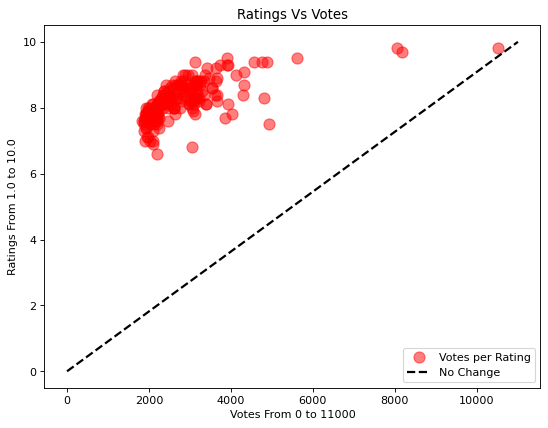

In [438]:
# For Votes
plt.figure(figsize=(8,6), dpi=80)
x = [0,11000]
y_plot = [0,10]
plt.scatter(votes, ratings_list, s=100, c='red', alpha=0.5, label="Votes per Rating")
plt.plot(x, y_plot, color='black', linestyle = "dashed", linewidth=2, label="No Change")
plt.title("Ratings Vs Votes")
plt.xlabel("Votes From 0 to 11000")
plt.ylabel("Ratings From 1.0 to 10.0")
plt.legend(loc = 4)
plt.show()

### Reflection 
We were able to receive an accuracy of 86% and an error rate of 14%. We believe the accuracy is strong because the votes are directly correlated to creating the rating. So it makes sense for that purely basing the prediction off the votes would yield a high accuracy. We can also see that the office's rating out performs a typical show's rating based on the number of votes. Meaning the audience could really enjoy the show per vote.

# Prediction Based on Most Weighted Attributes
After finding what attributes have the strongest affect on the accuracy of the prediction, we thought it would be prudent to run a prediction on those attributes. In this Accuracy model we will prediction against the Viewership, Votes, and Directed/WrittenBy attributes

In [439]:
# We retain the same Y from the previous Naive Bayes Classification
# Extract the Writers column from the dataframe

viewership = list(the_office_data.get("Viewership"))
writers = list(the_office_data.get("WrittenBy"))
directors = list(the_office_data.get("DirectedBy"))
votes = list(the_office_data.get("Votes"))
about = list(the_office_data.get("About"))

# Build X with the remaining data
X = [[about[i], votes[i], viewership[i], directors[i], writers[i]] for i in range(len(votes))]

print("===================================================")
print("Dummy Classifier Report With Complete Data Set")
print("===================================================")
print("Dummy Classifier: accuracy = "\
    + str(dummy_accuracy) + ", error rate = " + str(dummy_error_rate))
print("Precision: ", round(dummy_precision, 2))
print("Recall: ", round(dummy_recall, 2))
print("F-1: ", round(dummy_f_one, 2))
print()

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Most Weighted Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

tree_accuracy, tree_error_rate, tree_y_true, tree_y_pred = project_utils.cross_val_predict(\
    X, y, eval, DecisionTree_clf(), True)

tree_precision = eval.binary_precision_score(tree_y_true, tree_y_pred, None, 8)
tree_recall = eval.binary_recall_score(tree_y_true, tree_y_pred, None, 8)
tree_f_one = eval.binary_f1_score(tree_y_true, tree_y_pred, None, 8)

print("===================================================")
print("Decision Tree Classifier Report With Complete Data Set")
print("===================================================")
print("Decision Tree Classifier: accuracy = "\
    + str(tree_accuracy) + ", error rate = " + str(tree_error_rate))
print("Precision: ", round(tree_precision, 2))
print("Recall: ", round(tree_recall, 2))
print("F-1: ", round(tree_f_one, 2))
print()

Dummy Classifier Report With Complete Data Set
Dummy Classifier: accuracy = 0.65, error rate = 0.35
Precision:  0.64
Recall:  1.0
F-1:  0.78

Naive Bayes Classifier Report With Most Weighted Data Set
Naive Bayes Classifier: accuracy = 0.87, error rate = 0.13
Precision:  1.0
Recall:  1.0
F-1:  1.0

Decision Tree Classifier Report With Complete Data Set
Decision Tree Classifier: accuracy = 0.89, error rate = 0.11
Precision:  0.98
Recall:  0.99
F-1:  0.99



#### Reflection
We were able to recieve an accuracy of 87% and an error rate of 13%. This shows we were able to get rid of attributes that little to no affect on the accuracy of the classifier. The accuracy is one percent better than the classification based on votes so we can also conclude that "votes" is a very dominant attribute. Meaning, the other attributes in this classification could be supporting and votes being the main logic behind the decision. We ran the same prediction while including the GuestStars column and recieved the same prediction accuracy. This informs us that the About, Votes, Viewership, DirectedBy, and WrittenBy columns are the most important attributes to make predictions on. 

In [440]:
r_tree_accuracy, r_tree_error_rate, r_tree_y_true, r_tree_y_pred = project_utils.train_test_predict(\
    X, y, eval, RandomForest_clf(30, 5, 4))

r_tree_precision = eval.binary_precision_score(r_tree_y_true, r_tree_y_pred, None, 8)
r_tree_recall = eval.binary_recall_score(r_tree_y_true, r_tree_y_pred, None, 8)
r_tree_f_one = eval.binary_f1_score(r_tree_y_true, r_tree_y_pred, None, 8)

print("===================================================")
print("Random Forest Classifier Report With Complete Data Set")
print("===================================================")
print("Random Forest Classifier: accuracy = "\
    + str(r_tree_accuracy) + ", error rate = " + str(r_tree_error_rate))
print("Precision: ", round(r_tree_precision, 2))
print("Recall: ", round(r_tree_recall, 2))
print("F-1: ", round(r_tree_f_one, 2))
print()

Random Forest Classifier Report With Complete Data Set
Random Forest Classifier: accuracy = 0.0, error rate = 1.0
Precision:  0.4
Recall:  0.05
F-1:  0.09



# Problems with the Random Forest Classifier
* As mentioned near the beginning of this notebook, we ran into problems with the implementation of the Random Forest Classifier
* This can be seen above once again. We are able to get predictions for a few instances of X_test however for the majority of the instances it returns nothing

## Visualization 
After finding that "Votes" was our strongest attribute and attributed the highest accuracy, we wanted to run comparisons to see how the director, writer, and viewership relationship was connected. We used two bar graphs to easily visualize what directors and writers were the most successful. A scatter plot was then used to compare the votes and viewship. This was to see what kind of affect viewership had on the votes.

#### Bar Charts For Directors and Writers

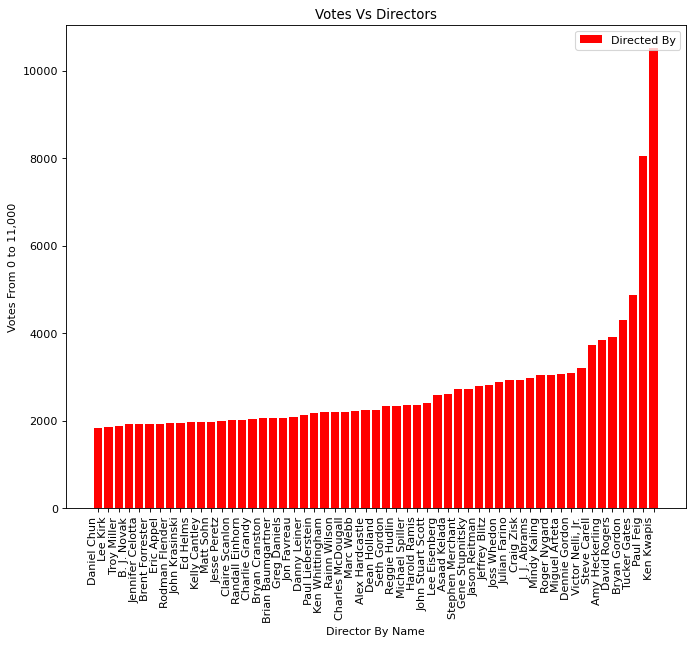

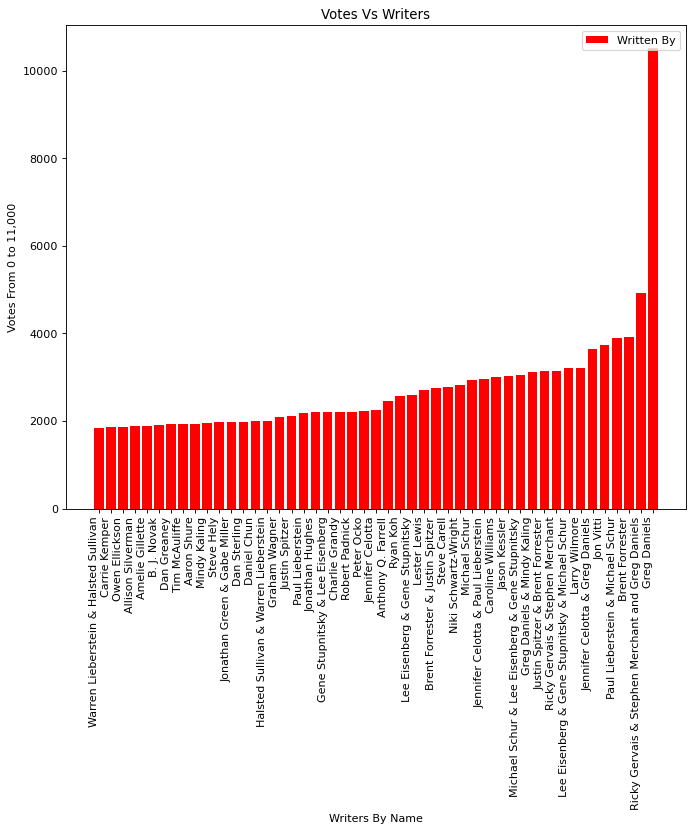

In [441]:
# Sorting the Vote by Director Dictionary so it is more presentable to read
director_dir = {}
tempVotes = votes.copy()
for key in directors:
    for value in tempVotes:
        director_dir[key] = value
        tempVotes.remove(value)
        break
    
keys = list(director_dir.keys())
values = list(director_dir.values())
sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

dir_name = list(sorted_dict.keys())
dir_votes = list(sorted_dict.values())

# Displaying the votes by director in a bar graph
plt.figure(figsize=(10,8), dpi=80)
plt.bar(dir_name, dir_votes, color='red', label="Directed By")
plt.title("Votes Vs Directors")
plt.xlabel("Director By Name")
plt.ylabel("Votes From 0 to 11,000")
plt.legend(loc = 1)
plt.xticks(rotation=90, ha='right') 
plt.show()

# Sorting the Vote by Writer Dictionary so it is more presentable to read
writer_dir = {}
writerVotes = votes.copy()
for key in writers:
    for value in writerVotes:
        writer_dir[key] = value
        writerVotes.remove(value)
        break
    
keys = list(writer_dir.keys())
values = list(writer_dir.values())
sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

wri_name = list(sorted_dict.keys())
wri_votes = list(sorted_dict.values())
plt.figure(figsize=(10,8), dpi=80)
plt.bar(wri_name, wri_votes, color='red', label="Written By")
plt.title("Votes Vs Writers")
plt.xlabel("Writers By Name")
plt.ylabel("Votes From 0 to 11,000")
plt.legend(loc = 1)
plt.xticks(rotation=90, ha='right') 
plt.show()

#### Scatter Plot For Viewership

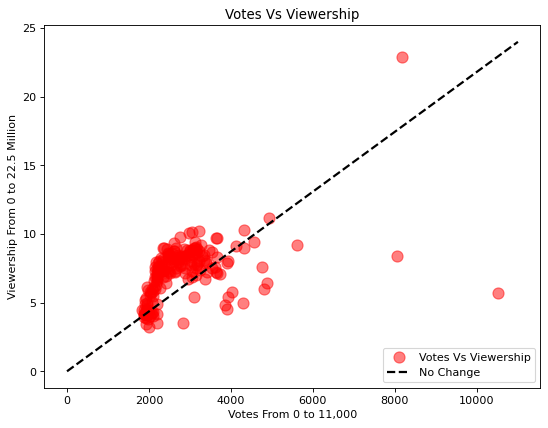

In [442]:
plt.figure(figsize=(8,6), dpi=80)
x = [0,11000]
y_plot = [0, 24]
plt.scatter(votes, viewership, s=100, c='red', alpha=0.5, label="Votes Vs Viewership")
plt.plot(x, y_plot, color='black', linestyle = "dashed", linewidth=2, label="No Change")
plt.title("Votes Vs Viewership")
plt.xlabel("Votes From 0 to 11,000")
plt.ylabel("Viewership From 0 to 22.5 Million")
plt.legend(loc = 4)
plt.show()

#### Reflection
From the bar graphs we are able to understand correlations between the writers and directors. We can see Kert Kwapis is a notable director and Greg Daniels is a notable writer for the office. This could lead to the producers of the office to invite Mr. Kwapis or Mr. Daniels back to write and direct new episodes. We are also able to see the opposite, where Daniel Cuhn and Warren Lieberstein/Hallsted Sullivan were neither a notable writer or director. Meaning the producers of the office potentially might not invite Mr. Cuhn and Mr.Lieberstein/Mr. Sullivan back for future episodes. Through the scatter plot we are able to see what episodes got a high viewership when comparing to the votes. We can see there are a few episodes that should've gotten less votes for the amount of views they got. We can also see that a majority of episodes should've received more votes. We can also notice that the episodes that had more votes than expected viewers could be bad episodes the audience wanted to voice. It could also mean that the episodes were great but only the core fans really enjoyed the experience. 